In [2]:
import numpy as np
import pylab as pl
from astropy.io import fits
from matplotlib import cm
cmap = cm.get_cmap('gray')
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import exposure
%matplotlib inline


In [3]:
PATH = 'data/ALICE_Machine-Learning/ALICE_RefCube_F110W_Era-2.fits'
data = fits.open(PATH)

In [4]:
data[0].shape

(809, 80, 80)

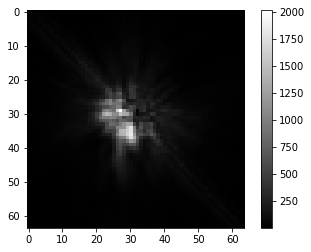

In [21]:
raw = data[0].data

image_data = cube_cut[14]
plt.imshow(image_data, cmap='gray')
plt.colorbar()


In [15]:
cube = data[0].data
Nframes = len(cube[:,0,0])
Ny  = 64
Nx  = 64

# ylow = 325
# xlow = 550

ylow = 10
xlow = 10

cube_cut = np.zeros((Nframes,Nx,Ny))
for i in range(Nframes):
    cube_cut[i,:,:] = cube[i,ylow:ylow+Ny,xlow:xlow+Nx]

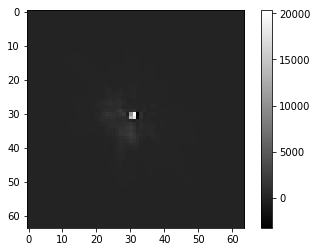

In [16]:

over_data = cube_cut[13]
plt.imshow(over_data, cmap='gray')
plt.colorbar()

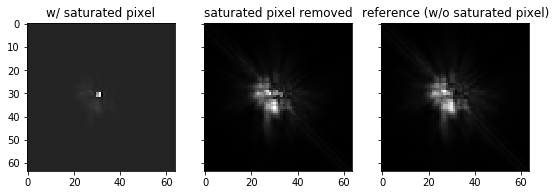

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].imshow(over_data, cmap='gray')
axs[0].set_title("w/ saturated pixel")
axs[1].imshow(new_image, cmap='gray')
axs[1].set_title("saturated pixel removed")
axs[2].imshow(image_data, cmap='gray')
axs[2].set_title("reference (w/o saturated pixel)")
plt.savefig("cleaned_img")

In [18]:
##remove overly saturated pixels
def find_outlier_pixels(data,tolerance=3,blur = 3):
    #This function finds the hot or dead pixels in a 2D dataset. 
    #tolerance is the number of standard deviations used to cutoff the hot pixels
    #If you want to ignore the edges and greatly speed up the code, then set
    #worry_about_edges to False.
    #
    #The function returns a list of hot pixels and also an image with with hot pixels removed

    from scipy.ndimage import median_filter
    
    blurred = median_filter(data, size=blur)
    difference = data - blurred
    threshold = 10*np.std(difference)

    #find the hot pixels, but ignore the edges
    hot_pixels = np.nonzero((difference[1:-1,1:-1]>threshold) )
    hot_pixels = np.array(hot_pixels) + 1 #because we ignored the first row and first column
    fixed_image = np.copy(data) #This is the image with the hot pixels removed
    for y,x in zip(hot_pixels[0],hot_pixels[1]):
        fixed_image[y,x]=blurred[y,x]

    dead_pixels = np.nonzero(data<-10)
    for y,x in zip(dead_pixels[0],dead_pixels[1]):
        fixed_image[y,x]=blurred[y,x]

    return fixed_image,blurred

Mean: 2.24262905121


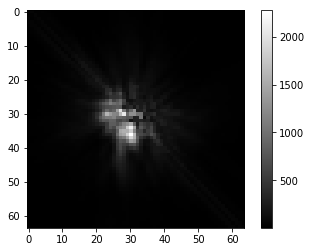

In [19]:
#inspect the cleaned image
new_image,blurred = find_outlier_pixels(cube_cut[13])
plt.imshow(new_image, cmap='gray')
plt.colorbar()
print('Mean:', np.min(new_image))

In [11]:
##new data cube with cleaned images inside

white_out_list = np.array([])
new_data_cube = []
for i in range(len(cube_cut)):
    if np.max(cube_cut[i]) > 10000:
        white_out_list = np.append(white_out_list,i)
        new_image,_ = find_outlier_pixels(cube_cut[i])
        new_data_cube.append(new_image)
    else:
        new_data_cube.append(cube_cut[i])

new_data_cube = np.array(new_data_cube)
np.max(new_data_cube)

44919.0546875

In [12]:
## leave out images that are still overly saturated. 
data_cube_with_cleaned = []
for i in range(len(new_data_cube)):
    if np.max(new_data_cube[i]) > 10000:
        pass
    else:
        data_cube_with_cleaned.append(new_data_cube[i])

In [13]:
np.array(data_cube_with_cleaned).shape

(803, 64, 64)

In [14]:
### new data cube without images with overly-saturated points. 
data_cube_without_saturation = []
for i in range(len(cube_cut)):
    if np.max(cube_cut[i]) > 10000:
        pass
    else:
        data_cube_without_saturation.append(cube_cut[i])



In [15]:
np.array(data_cube_without_saturation).shape

(742, 64, 64)

15.154723679270749

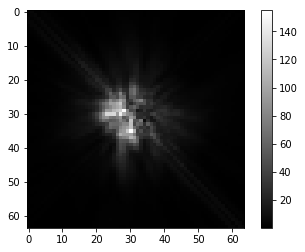

In [16]:
#inspect residual between cleaned dataset and reduced dataset
averaged_image_with = np.mean(data_cube_with_cleaned,axis=0)
averaged_image_without = np.mean(data_cube_without_saturation,axis=0)
res = averaged_image_with - averaged_image_without
plt.imshow(res, cmap='gray')
plt.colorbar()
np.std(res)



In [17]:
#normalisation
def normalise_cube(data):
    
    print(np.min(data))
    print(np.max(data))

    new_data = data - np.min(data)
    new_data = data / np.max(data)

    print(np.min(new_data))
    print(np.max(new_data))

    # ble = (cube[0,:,:]-min1)*(((max2-min2)/(max1-min1))+min2)
    ble = new_data[0,:,:]

    p2 = np.percentile(new_data, 0.2)
    p98 = np.percentile(new_data, 99.8)
    img_rescale = exposure.rescale_intensity(ble, in_range=(p2, p98))

    pl.imshow(new_data[0,:,:], cmap=cmap)

    # # pl.ion()
    for i in range(10):
        pl.figure(figsize=(10,10))    
        img_rescale = exposure.rescale_intensity(new_data[i,:,:], in_range=(p2, p98))
        pl.imshow(img_rescale, cmap=cmap)
    return new_data
    

## Data augmentation
#for now  I have only implemented noise filter, blurring.

In [5]:
import imgaug as ia 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.8
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /Users/gordonyip/anaconda2/envs/py36

  added / updated specs: 
    - opencv


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pixman-0.34.0              |       hca0a616_3         597 KB
    graphite2-1.3.12           |       h2098e52_2          82 KB
    harfbuzz-1.8.8             |       hb8d4a28_0         703 KB
    py-opencv-3.4.2            |   py36h7c891bd_1         1.3 MB
    openssl-1.0.2p             |       h1de35cc_0         3.4 MB
    bzip2-1.0.6                |       h1de35cc_5         149 KB
    xz-5.2.4                   |       h1de35cc_4         269 KB
    certifi-2018.8.24          |           py36_1         139 KB
    libtiff-4.0.

In [6]:
from imgaug import augmenters as iaa

In [289]:
#train test split
train_idx = int(len(data_cube_with_cleaned)*0.9)

training = data_cube_with_cleaned[:train_idx]
test = data_cube_with_cleaned[train_idx:]
np.shape(training)

(722, 64, 64)

In [290]:
blur_list = [0.3,0.5,0.7]
noise_list = [0.3,0.5,0.7]
aug_images = []
number_of_batches = 2
for iterations in range(number_of_batches):
    for i in range(len(training)):
        rand_idx = np.random.randint(3)
        rand_idx2 = np.random.randint(3)
        noise = np.random.randn(64,64)*np.mean(training[i]*noise_list[rand_idx2])
        blurer = iaa.GaussianBlur(blur_list[rand_idx])
        img_aft_aug = blurer.augment_image(training[i])
        img_aft_aug = noise + img_aft_aug
        aug_images.append(img_aft_aug)
    
np.array(aug_images).shape

(1444, 64, 64)

In [291]:
train_image = np.vstack([training,aug_images])
train_image.shape

(2166, 64, 64)

-863.233190186
9056.78417969
-0.095313432788
1.0
-14.9800844193
4870.85791016
-0.00307545091554
1.0


/Users/gordonyip/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


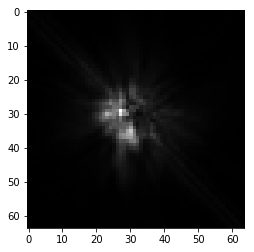

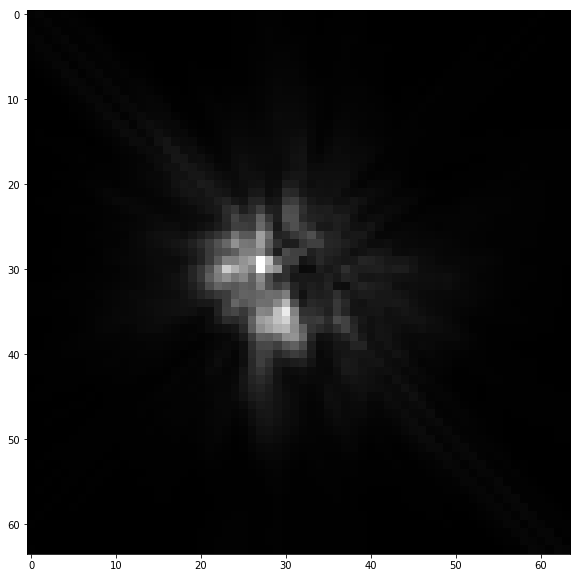

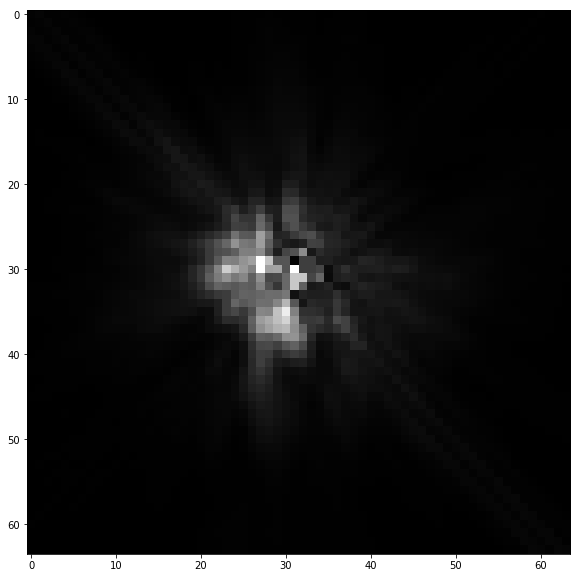

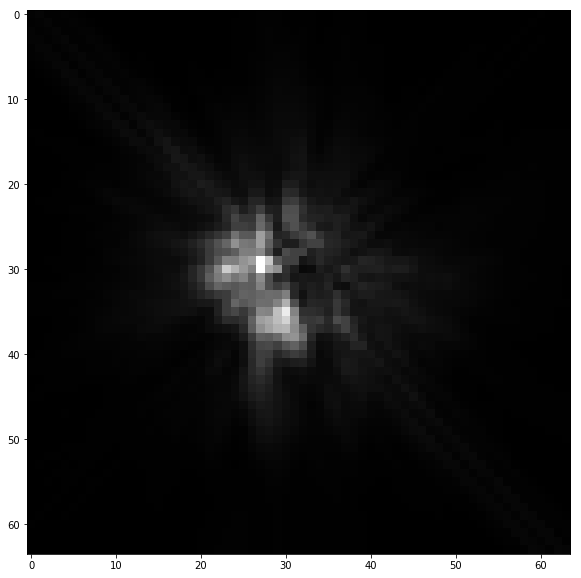

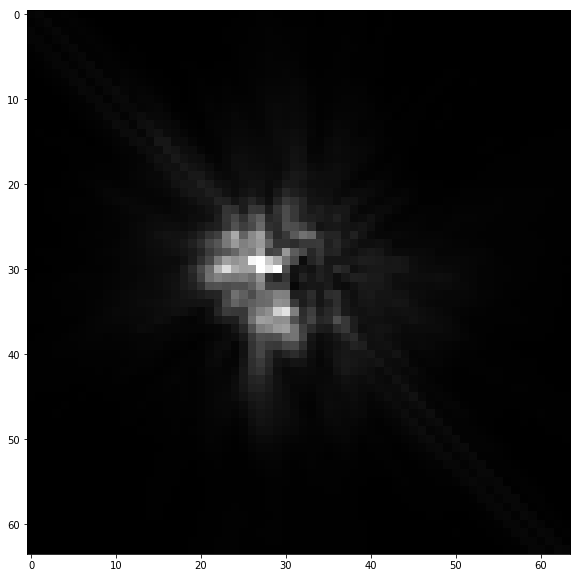

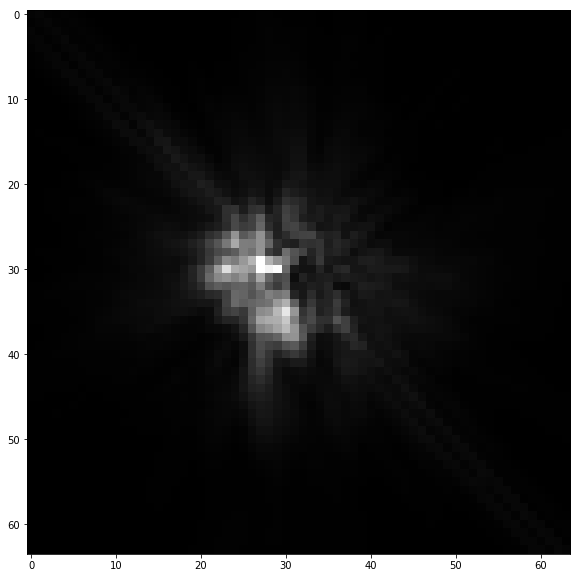

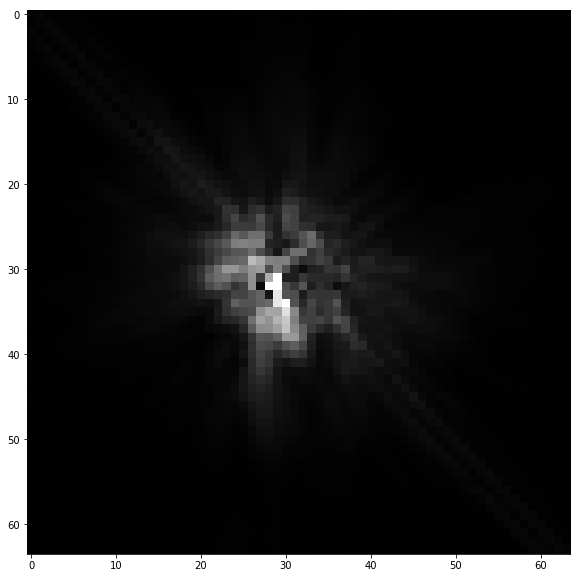

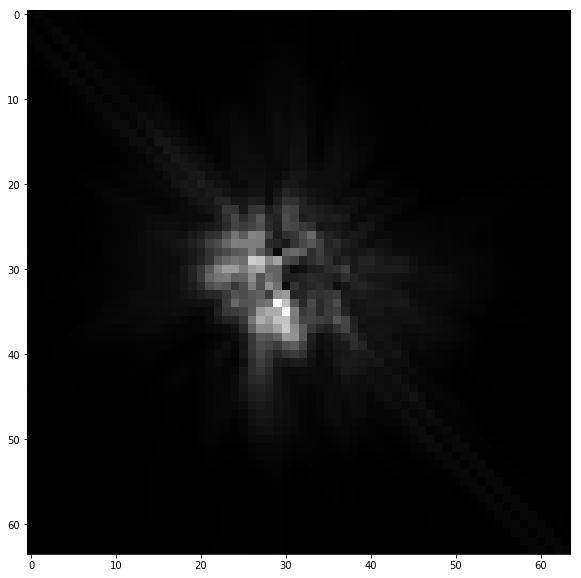

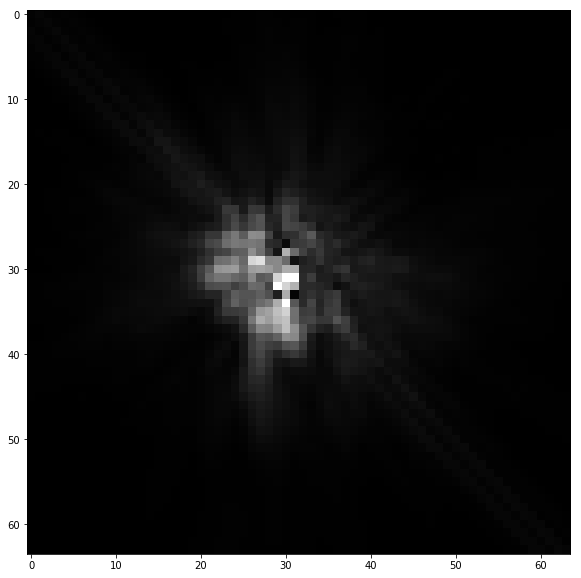

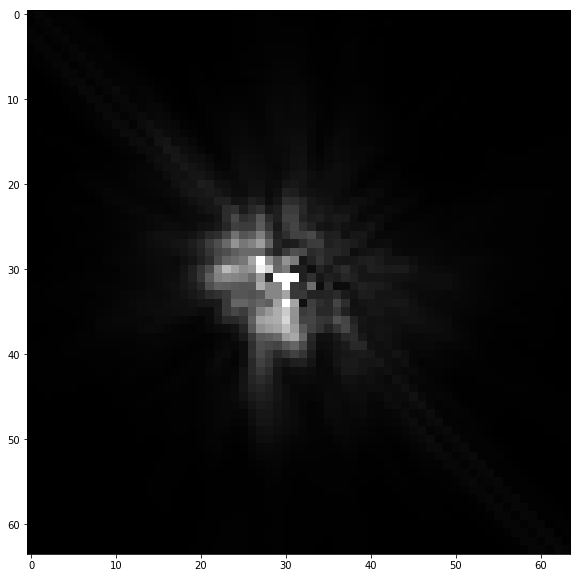

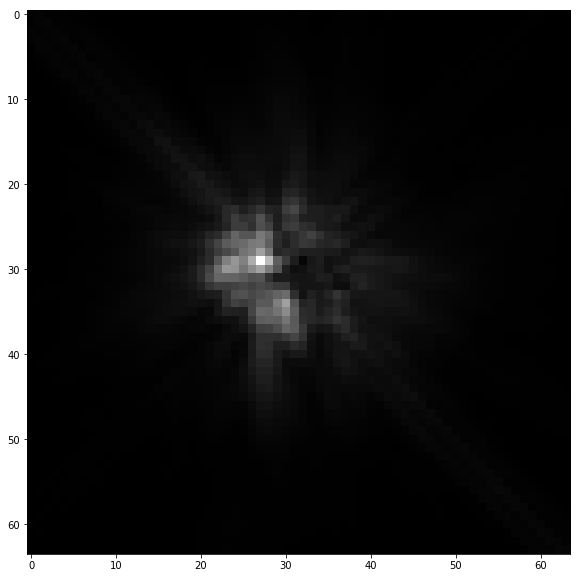

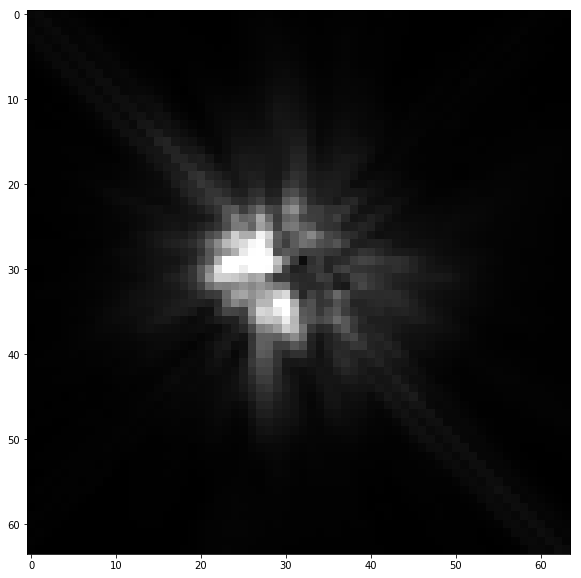

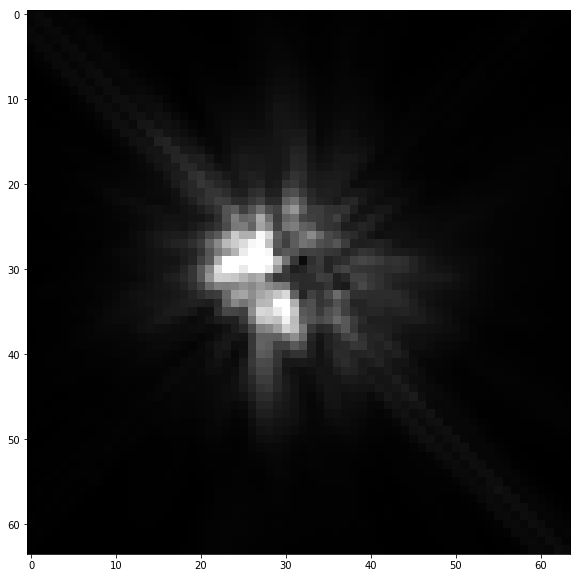

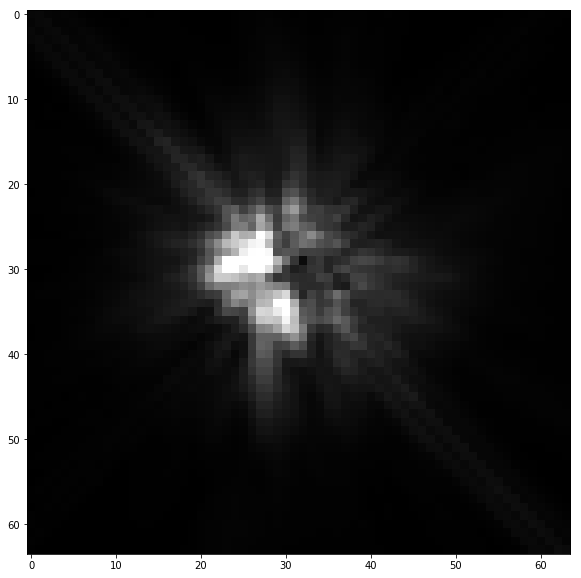

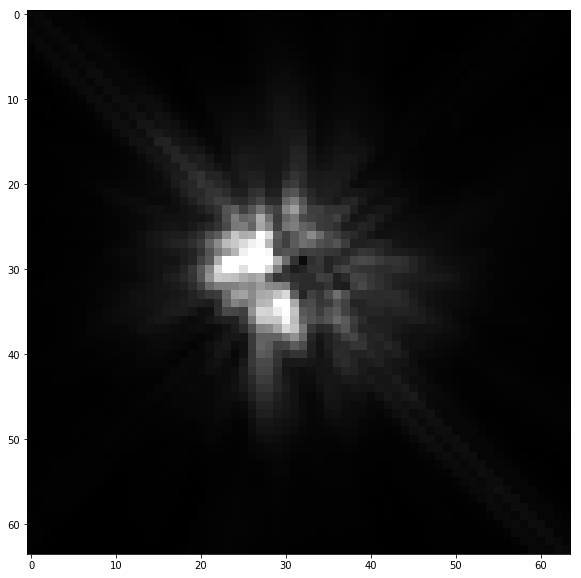

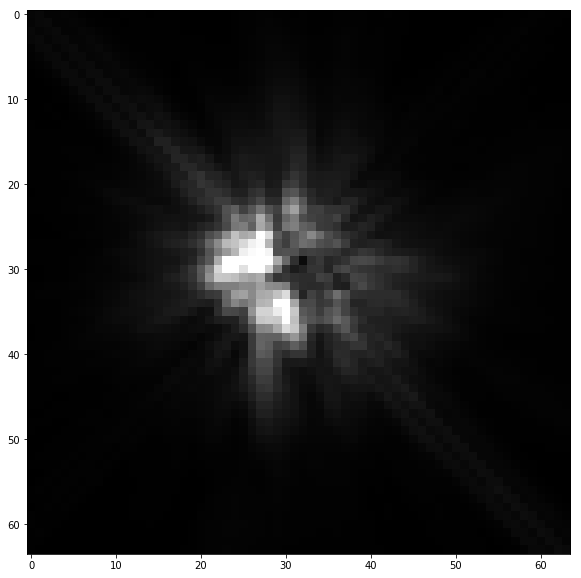

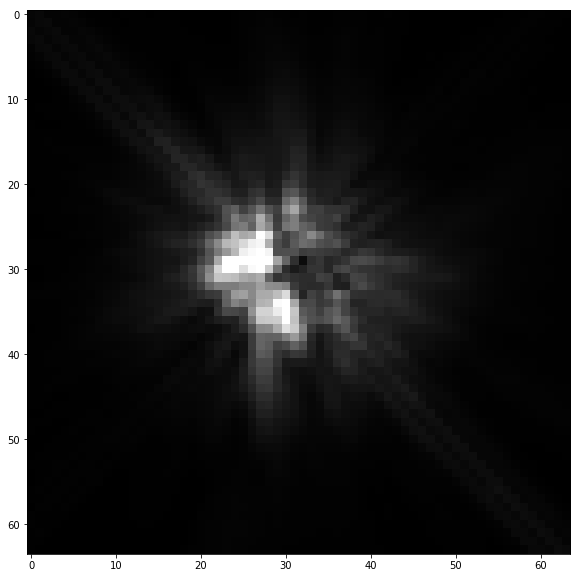

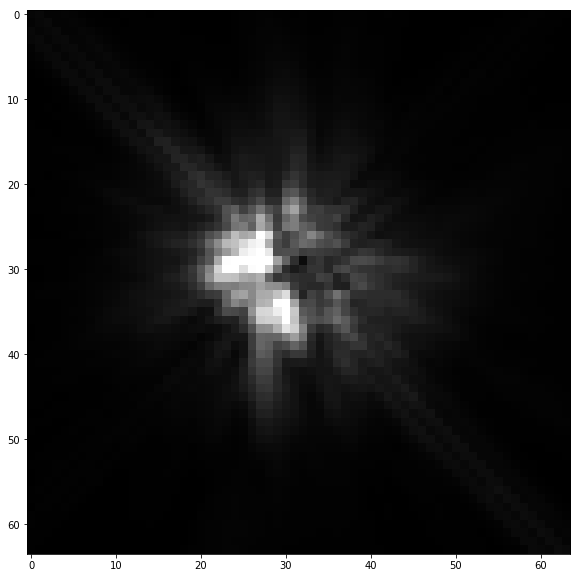

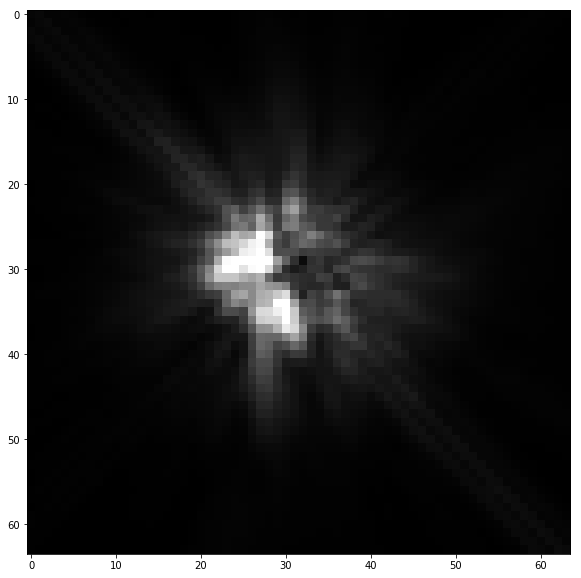

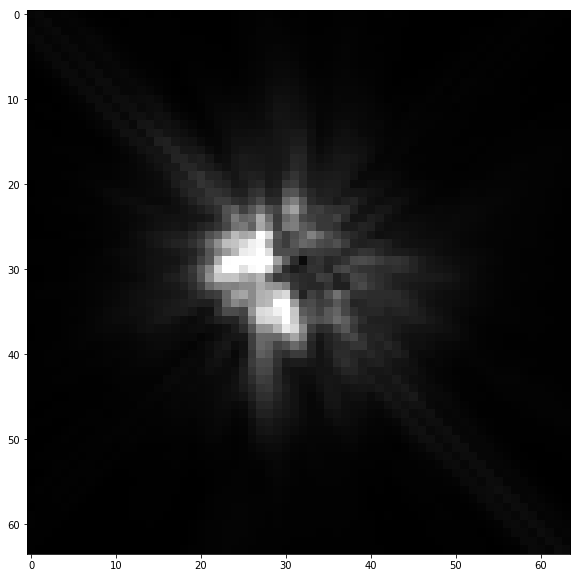

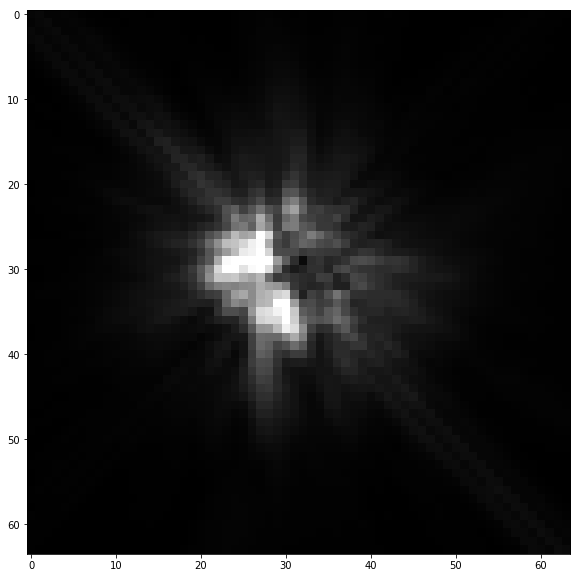

In [293]:
normalised_training_set = normalise_cube(train_image)
normalised_test_set = normalise_cube(test)

In [294]:
np.save('normalised_cleaned_sasha_train', normalised_training_set)
np.save('normalised_cleaned_sasha_test', normalised_test_set)